In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy

from collections import defaultdict 

from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm

# warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80

### Эксперимент

#### Фиксированные параметры генератора
- series_type = "default"  // обычная линейная регрессия

- dim=10 // размерность сигнала
- low=-10, high=10 // границы весов для получения отклика
- noise_var=1 // дисперсия нормального шума
- workers_num=3 // число различных генераторов
- lower_bound=100, upper_bound=400 // границы длин каждого из кусков, получаемых генератором
- alternating=True // нет двух подряд кусков одного типа
#### Фиксированные параметры алгоритма
- from_start=False // начинаем подсчет всех потерь (и составного эксперта) не с самого начала, а после того как прошли по одному разу учатки каждого из  генераторов

- length=1500 // длина изучаемого участка временного ряда

- a=-40, b=40 // параметры алгоритма, отклики отсеиваем тоже по ним

#### Гиперпараметры эксперимента
- windows = [5, 10, 20] // варьируем длину окна обучения ($\frac12x, 1x, 2x$ соответственно, где $x$  &mdash; dim  сигнала )
- weights_function // функция начальных весов, cравниваем $\dfrac1{x^\alpha}$ для разных $\alpha$ и дефолтную $\dfrac{1}{(x+1)\ln^2(x+1)}$
- alpha_function // функция коэффицента $\alpha$ в Mixing Update, cравниваем $\dfrac1{(1 + x)^\alpha}$ для разных $\alpha$

In [137]:
from hypers import weight_hypers
from hypers import alpha_hypers 

from experiment import results
from experiment import interesting_w, interesting_a
from experiment import windows

In [75]:
dct = {}
for result in results:
    key = (result.train_window, result.key_w, result.key_a)
    if key not in dct: 
        hyper_w = weight_hypers[result.key_w]
        hyper_a = alpha_hypers[result.key_a]
        dct[key] = [result.train_window, hyper_w.repr, hyper_a.repr]
    dct[key].append(round(result.regret, 2))

df = pd.DataFrame(dct).transpose()

labels = ["train_window", "weight_function", "alpha_function"]

renaming={}
for i in list(df):
    if i < 3:
        renaming[i] = labels[i]
    else:
        renaming[i] = f"random_{i-2}"

df = df.set_index(np.arange(df.index.size)).rename(columns=renaming)
ordered_repr = windows + [wh.repr for wh in weight_hypers.values()] + [ah.repr for ah in alpha_hypers.values()]
df = df.sort_values(labels, key=lambda col: col.apply(lambda x: ordered_repr.index(x)))
df.insert(3, "mean", df.iloc[:, 3:].mean(axis=1))
df["mean"] = df["mean"].astype(float).round(2)
df

,train_window,weight_function,alpha_function,mean,random_1,random_2,random_3,random_4
1,5,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),146660.14,137089.86,119326.04,156421.33,173803.31
4,5,1 / (x^1.05),1 / (x + 1),117063.92,109269.06,94646.34,121903.32,142436.95
7,5,1 / (x^1.05),1 / (x + 1)^1.1,113379.84,105746.56,90509.9,119452.69,137810.22
2,5,1 / (x^1.05),1 / (x + 1)^1.3,106046.66,98712.39,81700.23,114489.79,129284.24
0,5,1 / (x^1.05),1 / (x + 1)^1.5,102810.37,95464.24,77281.11,112603.69,125892.45
8,5,1 / (x^1.05),1 / (x + 1)^2),102901.73,95454.74,76122.54,113233.07,126796.57
3,5,1 / (x^1.1),1 / (x + 1),118359.33,110254.86,95576.91,123761.61,143843.93
6,5,1 / (x^1.2),1 / (x + 1),121174.36,112576.49,97434.36,127775.87,146910.71
5,5,1 / (x^2),1 / (x + 1),131360.72,118878.89,101627.18,148198.16,156738.67
10,10,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),93840.70,79840.65,87111.0,98238.14,110173.03


In [ ]:
# df.to_csv("df.csv", sep='\t')

In [106]:
df_w = df[df["alpha_function"] == "1 / (x + 1)"].iloc[:, :4]
df_w

,train_window,weight_function,alpha_function,mean
1,5,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),146660.14
4,5,1 / (x^1.05),1 / (x + 1),117063.92
3,5,1 / (x^1.1),1 / (x + 1),118359.33
6,5,1 / (x^1.2),1 / (x + 1),121174.36
5,5,1 / (x^2),1 / (x + 1),131360.72
10,10,1 / ((x + 1) * (ln(x + 1))^2),1 / (x + 1),93840.70
13,10,1 / (x^1.05),1 / (x + 1),67697.90
12,10,1 / (x^1.1),1 / (x + 1),68943.76
15,10,1 / (x^1.2),1 / (x + 1),71145.19
14,10,1 / (x^2),1 / (x + 1),81754.42


In [99]:
df_a = df[df["weight_function"] == "1 / (x^1.05)"].iloc[:,:4]
df_a

,train_window,weight_function,alpha_function,mean
4,5,1 / (x^1.05),1 / (x + 1),117063.92
7,5,1 / (x^1.05),1 / (x + 1)^1.1,113379.84
2,5,1 / (x^1.05),1 / (x + 1)^1.3,106046.66
0,5,1 / (x^1.05),1 / (x + 1)^1.5,102810.37
8,5,1 / (x^1.05),1 / (x + 1)^2),102901.73
13,10,1 / (x^1.05),1 / (x + 1),67697.90
16,10,1 / (x^1.05),1 / (x + 1)^1.1,64498.46
11,10,1 / (x^1.05),1 / (x + 1)^1.3,62646.62
9,10,1 / (x^1.05),1 / (x + 1)^1.5,67644.99
17,10,1 / (x^1.05),1 / (x + 1)^2),73251.04


In [88]:
df[["train_window", "mean"]].groupby("train_window").mean()

,mean
train_window,
5,117750.785556
10,72380.342222
20,86215.462222


#### Выводы

##### Train window
В среднем, при окне обучения равном dim=10, результаты оказались лучше чем для размеров 5 и 20.

##### Weights function
При всех рассмотренных окнах, регрет для функции весов $\dfrac1{x^\alpha}$ меньше, чем для дефолтной $\dfrac{1}{(x+1)\ln^2(x+1)}$, и при стремлении $\alpha$ к 1 регрет уменьшается. То есть минимальный регрет среди рассмотренных здесь достигается  для $\dfrac1{x^{1.05}}$, она же была мной зафиксирована для экспериментами над alpha_function.

##### Alpha function
При окнах обучения $5$ и $10$, побеждают $\dfrac1{(x+1)^{1.5}}$ и $\dfrac1{(x+1)^{1.3}}$, но отрыв от остальных не слишком велик. \
При окне $20$ побеждает дефолтная $\dfrac1{(x+1)}$ c нарастающим отрывом при увеличении $\alpha$

**Таким образом, на практике лучшей функцией для начальных весов является $\dfrac1{x^{1+\varepsilon}}$ c как можно меньшим $\varepsilon$**

**Значительных улучшений дефолтной функции $\dfrac1{(x+1)}$ для коэффицента $\alpha$ Mixing Update  пока нет**

Теоретическая оценка сверху выглядит нормально:

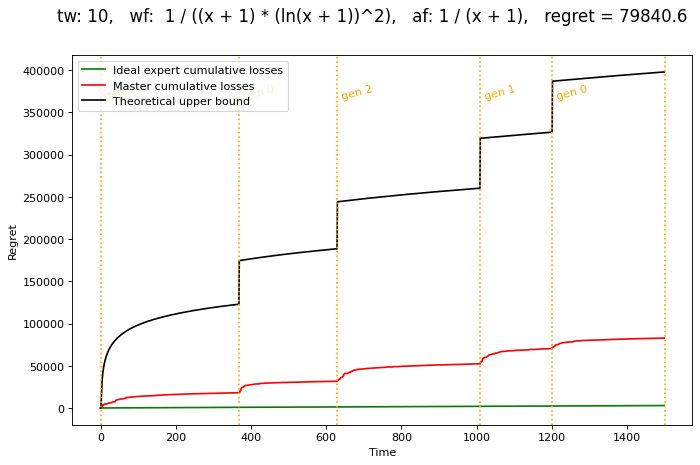

In [132]:
i = 10
results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
                              show_axes=["regret"], height_ratios=[1], 
                             suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},   af: {alpha_hypers[results[i].key_a].repr},   regret = {results[i].algo.regret:.1f}", 
                             fig_size=(10, 6))

In [136]:
# for i in df_w.index:
#     results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                              suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))

In [134]:
# for i in df_a.index:
#     results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                                 suptitle=f"tw: {results[i].train_window},   af:  {alpha_hypers[results[i].key_a].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))

In [135]:
# i = 13
# results[i].algo.draw_all(show=["master", "ideal", "theoretical"], show_experts=[], 
#                               show_axes=["regret"], height_ratios=[1], 
#                              suptitle=f"tw: {results[i].train_window},   wf:  {weight_hypers[results[i].key_w].repr},  regret = {results[i].algo.regret:.1f}", 
#                              fig_size=(6, 4))